In [1]:
#头文件
import os
import numpy as np
import pandas as pd
import math
from pandas import DataFrame
from xml.etree import ElementTree as ET
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D
from datetime import date
import tensorflow as tf 


Using TensorFlow backend.


In [2]:
#释放gpu
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:

#gpu训练
os.environ['KERAS_BACKEND']='tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']="0"
config=tf.compat.v1.ConfigProto() 
config.gpu_options.visible_device_list = '0' 
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess=tf.compat.v1.Session(config=config)


In [4]:
#读取数据
dataset=[]
def data_load():
    path='./traffic-matrices'
    FileList = os.listdir(path)
    for files in FileList:
        oldDirPath = path+'/'+files
        per=ET.parse(oldDirPath)
        p=per.findall('./IntraTM/src')
        matrix=np.zeros((23,23))
        for child in p:
            src=child.attrib['id']
            c=child.findall('dst')
            for i in c:
                dst=i.attrib['id']
                matrix[int(src)-1][int(dst)-1]=i.text
        dataset.append(matrix)
    datasets = np.array(dataset)
    return datasets
datasets = data_load()
datasets.shape

(10773, 23, 23)

In [5]:
#二维流量矩阵转一维
data = []
for i in range(len(datasets)):
    arr = []
    for row in datasets[i]:
        arr.extend(row)
    data.append(arr)
data = np.array(data)
data = data[:,40]
data.shape

(10773,)

In [6]:
#划分训练集和验证集
time_stamp = 120
train = data[6000:10600+time_stamp].reshape(-1,1)
valid = data[10600-time_stamp:-3].reshape(-1,1)
#归一化
scaler1 = MinMaxScaler(feature_range=(0, 1)) 
#训练集
scaled_data = scaler1.fit_transform(train)
x_train, y_train = [], []
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i])
x_train,y_train= np.array(x_train),np.array(y_train)
y_train = y_train.reshape(-1,1)
#验证集
scaled_data2 = scaler1.transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data2[i - time_stamp:i])
    y_valid.append(scaled_data2[i])
x_valid,y_valid = np.array(x_valid),np.array(y_valid)  
y_valid = y_valid.reshape(-1,1)
print(train.shape,x_train.shape,y_train.shape)

(4720, 1) (4600, 120, 1) (4600, 1)


In [7]:
# 超参数
epochs = 100
batch_size = 64
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
work = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_valid, y_valid), verbose=1)

D:\Program Files\Anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
D:\Program Files\Anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True, input_shape=(120, 1))`
  


Train on 4600 samples, validate on 170 samples
Epoch 1/50
4600/4600 [==============================] - 54s 12ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 2/50
4600/4600 [==============================] - 55s 12ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/50
4600/4600 [==============================] - 50s 11ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/50
4600/4600 [==============================] - 46s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/50
4600/4600 [==============================] - 52s 11ms/step - loss: 0.0014 - val_loss: 9.6042e-04
Epoch 6/50
4600/4600 [==============================] - 47s 10ms/step - loss: 0.0012 - val_loss: 9.3941e-04
Epoch 7/50
4600/4600 [==============================] - 46s 10ms/step - loss: 0.0012 - val_loss: 8.2634e-04
Epoch 8/50
4600/4600 [==============================] - 54s 12ms/step - loss: 0.0011 - val_loss: 9.7143e-04
Epoch 9/50
4600/4600 [==============================] - 53s 12ms/step - loss: 0.0011 - val_loss: 9.2563e-

In [8]:
#预测值
y = model.predict(x_valid)
# 反归一化
predict = scaler1.inverse_transform(y)
true = scaler1.inverse_transform(y_valid)
#rmse
rmse= np.sqrt(np.mean(np.power((true - predict), 2)))
print(rmse)
#MAPE
mape = np.mean(np.abs((true - predict) / true)) * 100
print(mape)

4516.729625307956
5.941087298334805


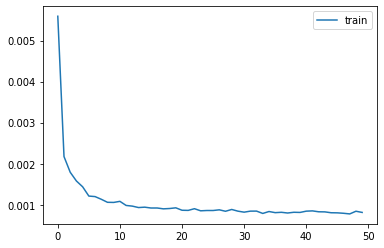

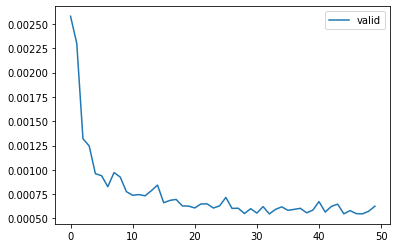

In [9]:
plt.plot(work.history['loss'], label='train')
plt.legend()
plt.show()
plt.plot(work.history['val_loss'], label='valid')
plt.legend()
plt.show()

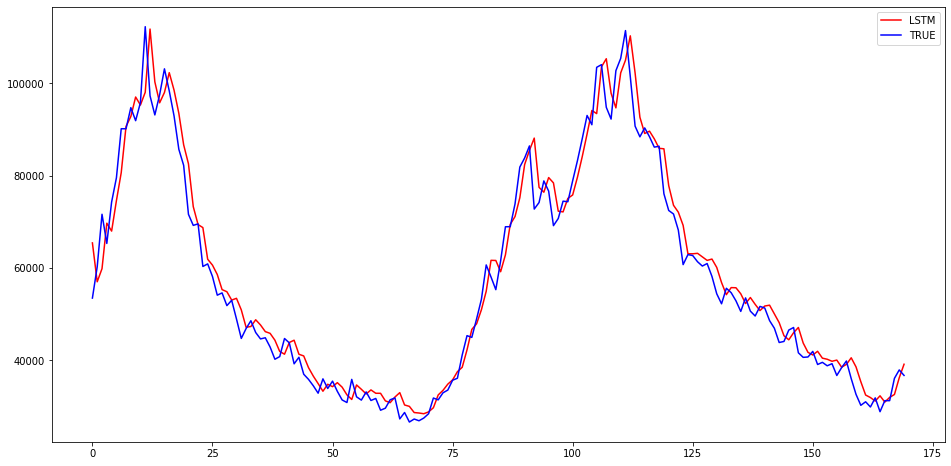

In [10]:
plt.figure(figsize=(16, 8))
predict = predict.reshape(1,-1)[0]
valid = true.reshape(1,-1)[0]
plt.plot(np.arange(len(predict)),predict,label='LSTM',color='r')
plt.plot(np.arange(len(valid)),valid,label='TRUE',color='b')
plt.legend()
plt.show()

(4600, 120, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120, 128)          66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


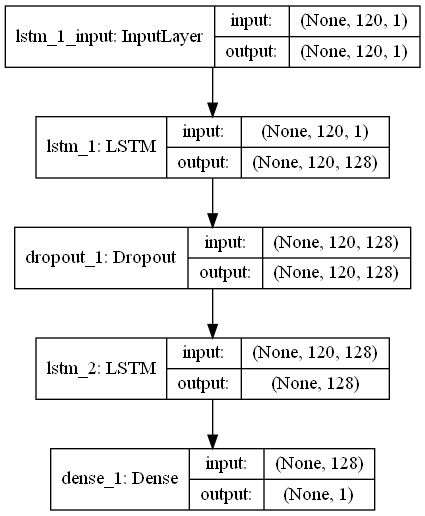

In [11]:
print(x_train.shape)
import keras
# 查看模型层及参数
model.summary()
# 将模型结构保存为图片
keras.utils.plot_model(model,to_file='%%latexstm.png', show_shapes=True)